# Image objects segmented with APOC

We will use the machine learning algorithm [apoc](https://github.com/haesleinhuepf/apoc) to identify microtubule crossings and then we'll image each identified crossing using our mock_scope


In [1]:
from skimage.io import imsave
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imread
import numpy as np
import matplotlib.pyplot as plt
import apoc
from microscope_gym.microscope_adapters.mock_scope import microscope_factory
from microscope_gym.features.smart_object_finder import SmartObjectFinder
import stackview


In [2]:
# helper function to plot all images
def plot_all(images):
    cols = np.sqrt(len(images)).astype(int)
    rows = np.ceil(len(images) / cols).astype(int)
    fig, ax = plt.subplots(rows, cols, figsize=(20, 20))
    for i, image in enumerate(images):
        cle.imshow(image, plot=ax.ravel()[i])
    for axis in ax.ravel():
        axis.set_axis_off()
    plt.tight_layout()
    plt.show()

## Set up and train an APOC model

This section of the notebook was adapted from [Robert Haases APOC notebook](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/20a_pixel_classification/apoc_object_segmenter.html) at the [Bio-image Analysis Notebooks](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/intro.html).


APOC is based on [pyclesperanto](https://github.com/clEsperanto/pyclesperanto_prototype) and [scikit-learn](https://scikit-learn.org/stable/). For object segmentation, it uses a pixel classifier and connected components labeling.

Let's start with loading an example image and some ground truth:

ion with APOC

This section of the notebook was adapted from [Robert Haases APOC notebook](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/20a_pixel_classification/apoc_object_segmenter.html) at the [Bio-image Analysis Notebooks](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/intro.html).


APOC is based on [pyclesperanto](https://github.com/clEsperanto/pyclesperanto_prototype) and [scikit-learn](https://scikit-learn.org/stable/). For object segmentation, it uses a pixel classifier and connected components labeling.

Let's start with loading an example image and some ground truth:

cl.OCLArray([[12857., 12095., 12748., ..., 10954., 12440., 12282.],
       [10402., 12988., 11687., ..., 12728., 14038., 12839.],
       [12199., 12239., 11810., ..., 13232., 12005., 11433.],
       ...,
       [14868., 13607., 12815., ..., 12374., 11965., 11034.],
       [11650., 13004., 13011., ..., 10943., 11881., 10532.],
       [14918., 12612., 13623., ..., 10996., 11870., 12409.]],
      dtype=float32)
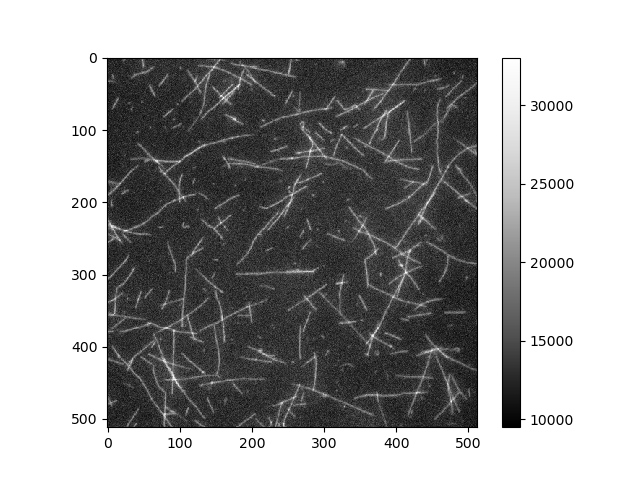
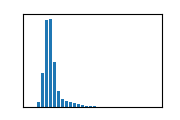

In [3]:
overview_image = imread('data/microtubules.tif')[4]
overview_image

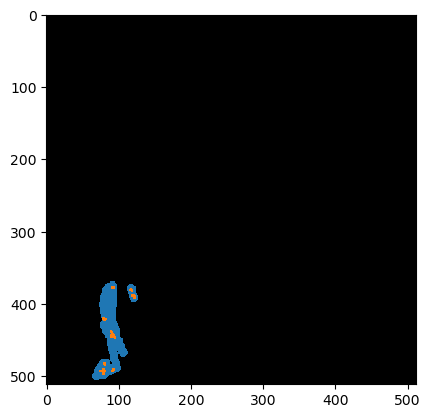

In [4]:
manual_annotations = imread('data/microtubules_manual_annotations.tif')

cle.imshow(manual_annotations, labels=True)

### Training
We now train a ObjectSegmenter, which is under the hood a [scikit-learn RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). After training, the classifier will be converted to [clij-compatible OpenCL code](https://github.com/clEsperanto/clij-opencl-kernels) and save to disk under a given filename.

In [5]:
# define features
features = apoc.PredefinedFeatureSet.object_size_1_to_5_px.value

# this is where the model will be saved
cl_filename = 'data/microtubules_object_segmenter.cl'

apoc.erase_classifier(cl_filename)
clf = apoc.ObjectSegmenter(opencl_filename=cl_filename, positive_class_identifier=2)
clf.train(features, manual_annotations, overview_image)

## Imaging z stacks of each segmented microtubule crossing

### Set up a mock_scope

In [6]:
mock_scope = microscope_factory(overview_image=imread("data/microtubules.tif"),
                                camera_height_pixels=64, camera_width_pixels=64)
print('overview_image shape: ', mock_scope.camera.overview_image.shape)
print('camera height: ', mock_scope.camera.height_pixels)
print('camera width: ', mock_scope.camera.width_pixels)
print('stage position: ', mock_scope.get_stage_position())

overview_image shape:  (11, 512, 512)
camera height:  64
camera width:  64
stage position:  (5.5, 256.0, 256.0)


### Use SmartObjectFinder to find the centroid positions

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
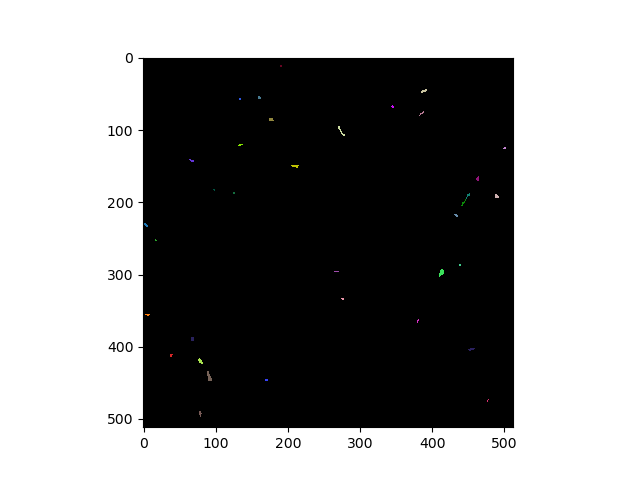

In [7]:
object_finder = SmartObjectFinder(mock_scope, clf, features)
segmentation = object_finder.find_objects_in_image(overview_image, object_size_range=(5, 1000))
segmentation


In [8]:
imaging_positions = object_finder.find_centroids(segmentation)
imaging_positions

array([[232.05263  ,   3.8421052],
       [355.85715  ,   5.428571 ],
       [253.28572  ,  17.714285 ],
       [412.5      ,  38.5      ],
       [142.38889  ,  66.111115 ],
       [389.6087   ,  68.13043  ],
       [420.59375  ,  79.15625  ],
       [493.       ,  78.75     ],
       [442.3729   ,  91.44068  ],
       [183.44444  ,  98.333336 ],
       [187.42857  , 125.71429  ],
       [121.3      , 134.5      ],
       [ 57.8      , 133.4      ],
       [ 55.5625   , 160.25     ],
       [446.8      , 170.7      ],
       [ 86.041664 , 177.29167  ],
       [ 12.       , 190.71428  ],
       [150.16667  , 210.3      ],
       [296.53333  , 267.26666  ],
       [102.702705 , 273.8919   ],
       [334.       , 275.8      ],
       [ 68.111115 , 344.66666  ],
       [364.7      , 379.8      ],
       [ 77.8      , 385.06668  ],
       [ 46.451614 , 388.4516   ],
       [298.1591   , 412.38635  ],
       [218.8125   , 433.1875   ],
       [287.5      , 438.       ],
       [201.42857  ,

### Image a z_stack at each centroid position

Some of the labels are too close to the edge, so we need to take care of the Value errors caused by moving the stage outside the safe range.

In [9]:
stacks = object_finder.image_found_objects(imaging_positions, imaging_function=mock_scope.acquire_z_stack)
print(f'Found {len(stacks)} images')

Found 35 images


because we used `mock_scope.acquire_z_stack`, the result is a list of 3D Stacks

In [10]:
stackview.slice(stacks[4], continuous_update=True, zoom_factor=5)


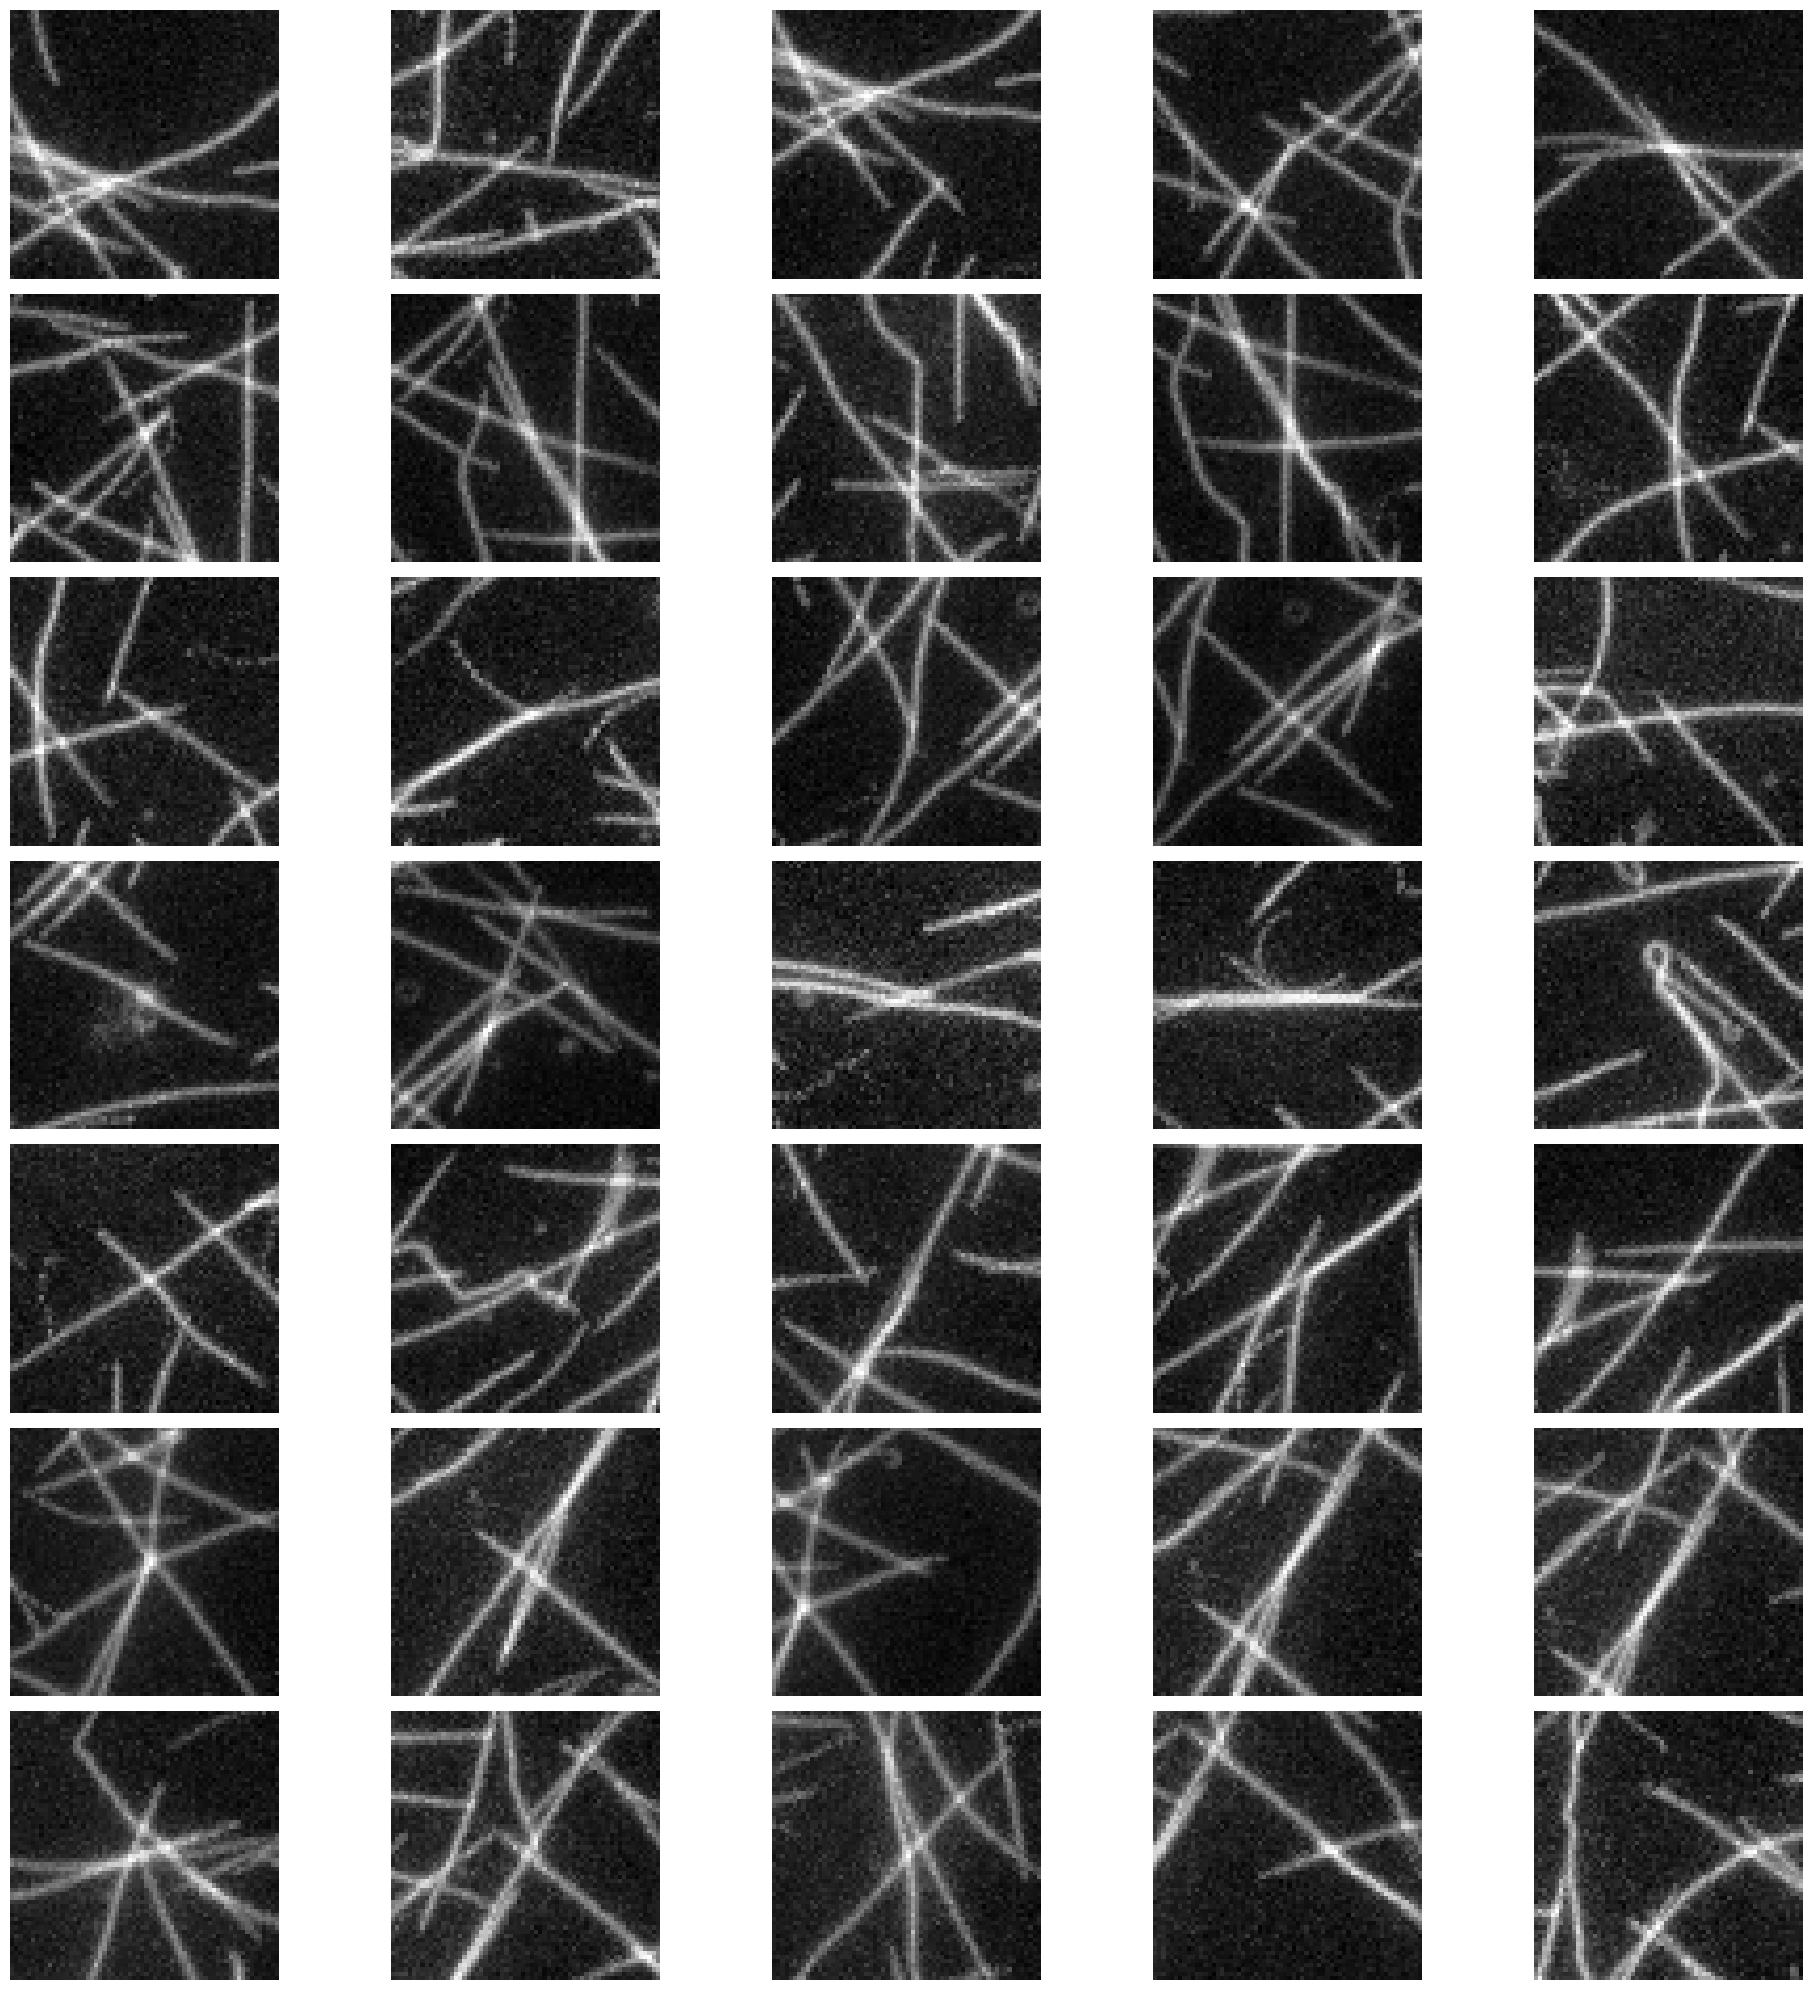

In [11]:
plot_all(stacks)

## Scanning for 10 events

Let's assume we don't have an overview image. Instead, well scan the entire sample until we found 10 microtubule crossings.

In [12]:
images = object_finder.scan_for_objects(num_objects=10, object_size_range=(5, 1000))
print(f'Found {len(images)} images')


Found 10 images


we got 10 image stacks of crossing microtubules:

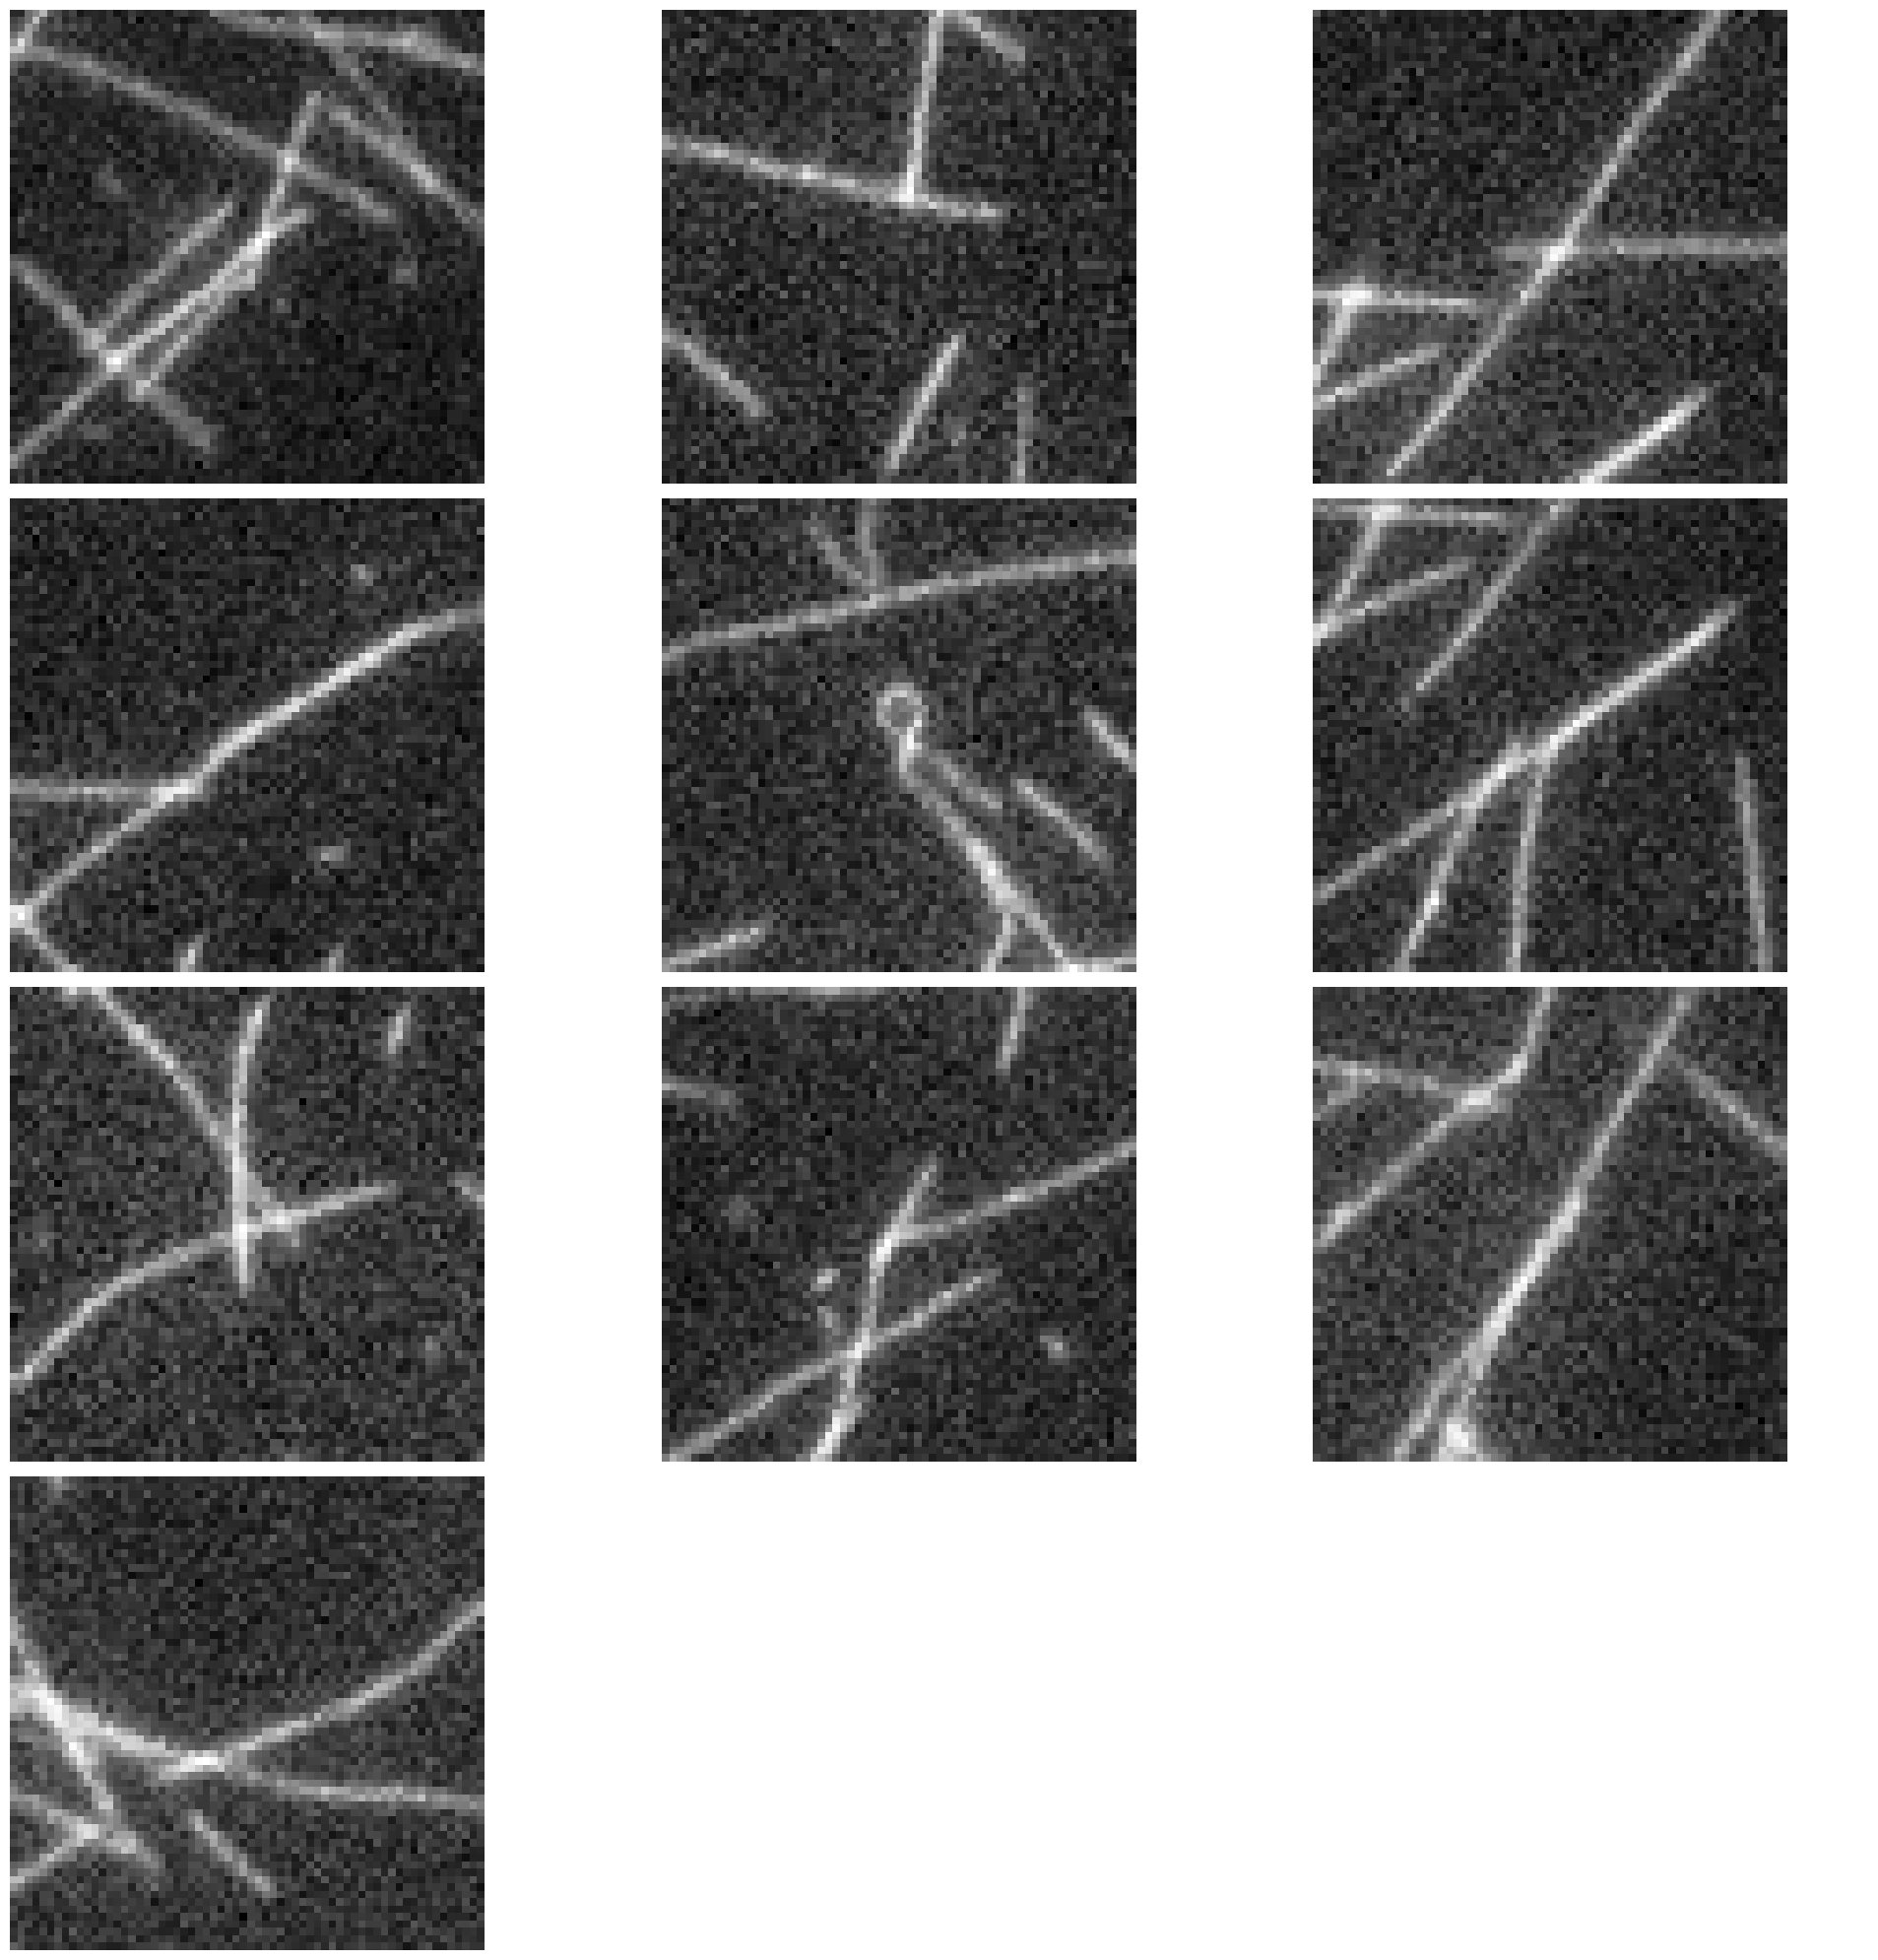

In [13]:
plot_all(images)

And we only needed to scan half the sample to find them:

In [14]:
mock_scope.get_stage_position()

(5.5, 234.6410255432129, 32)